# Кросс-валидация(перекрёстная проверка) - введение
Подробную документацию можно изучить здесь: https://scikit-learn.org/stable/modules/cross_validation.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../DATA/Advertising.csv')
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


---
---

## Разбиваем данные на обучающий и тестовый наборы данных - Train | Test Split
    0. Очищаем и подготавливаем данные для признаков X и целевой переменной y(при необходимости)
    1. Разьиваем данные на обучающие и тестовые наборы - как для признаков X, так и для целевой переменной y
    2. Обучаем объект *Scaler* на обучающих данных X
    3. Применяем масштабирование(scale) для тестовых данных X
    4. Создаём модель
    5. Обучаем модель на обучающих данных X
    6. Оцениваем модель на тестовых данных X(создавая предсказания и сравнивая их с y_test)
    7. Уточняем параметры модели, повторяя шаги 5 и 6

### Создаем X и y

In [8]:
# axis=1 для колонок
X = df.drop('sales', axis=1)
y = df['sales']

### Разбиение на Train и Test

In [11]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Масштабирование данных - Scale Data

In [17]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

In [21]:
# Обучаем ТОЛЬКО на X_test, чтобы избежать утечки данных
scaler.fit(X_train)

StandardScaler()

**Для масштабирования можно использовать как уже существующую переменную, так и создать новую.** Всё зависит от того, нужны ли будут в дальнейшем предыдущие версии признаков. При желании эти предыдущие версии признаков можно будет также взять из исходного датафрейма.

In [25]:
X_train = scaler.transform(X_train)

In [27]:
X_test = scaler.transform(X_test)

### Создаём модель

In [30]:
from sklearn.linear_model import Ridge

In [32]:
# Специально укажем большое значение alpha
model = Ridge(alpha=100)

### Обучение модели ТОЛЬКО на обучающем наборе данных

In [36]:
model.fit(X_train, y_train)

Ridge(alpha=100)

### Применяем модель для тестовых данных

In [39]:
y_pred = model.predict(X_test)

### Оценка модели

In [42]:
from sklearn.metrics import mean_squared_error

In [44]:
MSE = mean_squared_error(y_test, y_pred)
MSE

7.341775789034129

### Уточняем параметры и заново оцениваем модель
Цель состоит в том, чтобы улучшить метрику ошибки на обучающем наборе данных

In [48]:
model_two = Ridge(alpha=1)

### Заново обучаем модель

In [51]:
model_two.fit(X_train, y_train)

Ridge(alpha=1)

### Применяем модель для тестовых данных

In [54]:
y_pred_two = model_two.predict(X_test)

### Повторно оцениваем модель

In [57]:
MSE_two = mean_squared_error(y_test, y_pred_two)
MSE_two

2.3190215794287514

Значение метрики ошибки получилось намного лучше. Эти шаги можно повторять до тех пор, пока не получатся хорошие метрики производительности(ранее, для этой цели использовалось RidgeCV, но здесь можно обобщить процесс кросс-валидации для случая любой модели).

Плюсы такого подхода: 
* Простота выполнения
* Разбиение данных выполняется один раз, что может сэкономить вычислительные ресурсы в случае больших объёмов данных

Минусы такого подхода:
* Есть неудобство в поиске гиперпараметров
* Вычисленная метрика может не вполне корректно оценивать работу модели, так как при повторном обучении модели мы не можем с уверенностью сказать, что модель никогда не видела тестовые данные. Мы указали новое значение alpha используя результаты предыдущей модели, поэтому, хотя модель и не видела тестовые данные, мы сами при настройке гиперпараметров использовали тестовые данные. Получается, что мы не явно используем некоторую информацию из тестового набора для создания оптимальной модели, из-за чего мы не можем сказать, что оценка работы на тестовых данных является объективной. Для этого необходимо в самом начале отложить часть данных и не использовать их ни в обучении, ни в настройке гиперпараметров. Таким образом, мы получим возможность вычислить некоторую финальную метрику, которая будет оценивать работу модели.

---
---

## Обучение - валидация - тестирование (Train | Validation | Test Split Procedure)
Разбиение Train | Test не позволяет отложить часть данных для оценки модели - такие данные, которые модель ещё не видела. Оптимизация гиперпараметров на тестовых данных оправданна, и обычно не считается "утечкой данных". Но потенциально - это может влиять на корректность оценки модели.

Этот подход ещё называют методом с задержкой ("hold-out"), потому что здесь мы не настраиваем параметры модели на финальном тестовом наборе данных, а используем тестовые данные *только* для оценки финального результата.

    0. Очищаем и масштабируем данные X и y (при необходимости)
    1. Разбиваем данные на обучающий, оценочный и тестовый наборы данных - как для X, так и для y
    2. Обучаем объект Scaler на обучающих данных X
    3. Масштабируем (scale) оценочные данные X
    4. Создаём модель
    5. Обучаем модель на обучающих данных X
    6. Оцениваем модель на оценочных данных X (создавая предсказания и сравнивая их с y_eval)
    7. Уточняем параметры модели, повторяя шаги 5 и 6
    8. Вычисляем финальные метрики на тестовом наборе данных (после этого уже нельзя возвращаться и делать уточнения!)

### Создаем X и y

In [67]:
# axis=1 для колонок
X = df.drop('sales', axis=1)

In [69]:
y = df['sales']

**Вызываем SPLIT дважды! Здесь мы создаём три набора данных - TRAIN, VALIDATION и TEST.**

In [72]:
from sklearn.model_selection import train_test_split

**70% данных определяем в обучающий набор, остальные 30% откладываем в сторону.**

In [75]:
X_train, X_OTHER, y_train, y_OTHER = train_test_split(X, y, test_size=0.3, random_state=101)

**Оставшиеся 30% разбиваем на оценочный и тестовый наборы данных. Каждый будет по 15% от исходного набора данных.** Здесь очень важен порядок передачи аргументов, именно в таком порядке их вернёт метод.

In [78]:
X_eval, X_test, y_eval, y_test = train_test_split(X_OTHER, y_OTHER, test_size=0.5, random_state=101)

In [84]:
len(df)

200

In [86]:
len(X_train)

140

In [88]:
len(X_eval)

30

In [90]:
len(X_test)

30

### Масштабирование данных

In [81]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)

### Создаём модель

In [95]:
from sklearn.linear_model import Ridge

In [97]:
# Специально указываем неудачное значение alpha
model = Ridge(alpha=100)

### Обучение модели ТОЛЬКО на обучающем наборе данных

In [100]:
model.fit(X_train, y_train)

Ridge(alpha=100)

### Применяем модель для данных evaluating

In [103]:
y_eval_pred = model.predict(X_eval)

### Оценка модели

In [106]:
from sklearn.metrics import mean_squared_error

In [108]:
MSE = mean_squared_error(y_eval, y_eval_pred)
MSE

7.320101458823872

### Уточняем параметры и заново оцениваем модель

In [114]:
model_two = Ridge(alpha=1)

### Заново обучаем модель

In [116]:
model_two.fit(X_train, y_train)

Ridge(alpha=1)

### Применяем модель для данных evaluating

In [119]:
new_pred_eval = model_two.predict(X_eval)

### Повторно оцениваем модель

In [121]:
MSE = mean_squared_error(y_eval, new_pred_eval)
MSE

2.3837830750569866

Возникает вопрос - насколько метрика корректно оценивает работу модели? Для выяснения финальной оценкьи используем данныe X_test. 

**Важно: перед этим необходимо убедиться в том, что настройка гиперпараметров модели завершена и результаты модели нас устраивают!**

In [128]:
y_final_test_pred = model_two.predict(X_test)

In [132]:
MSE = mean_squared_error(y_test, y_final_test_pred)
MSE

2.254260083800517

---
---

## Кросс-валидация с помощью cross_val_score

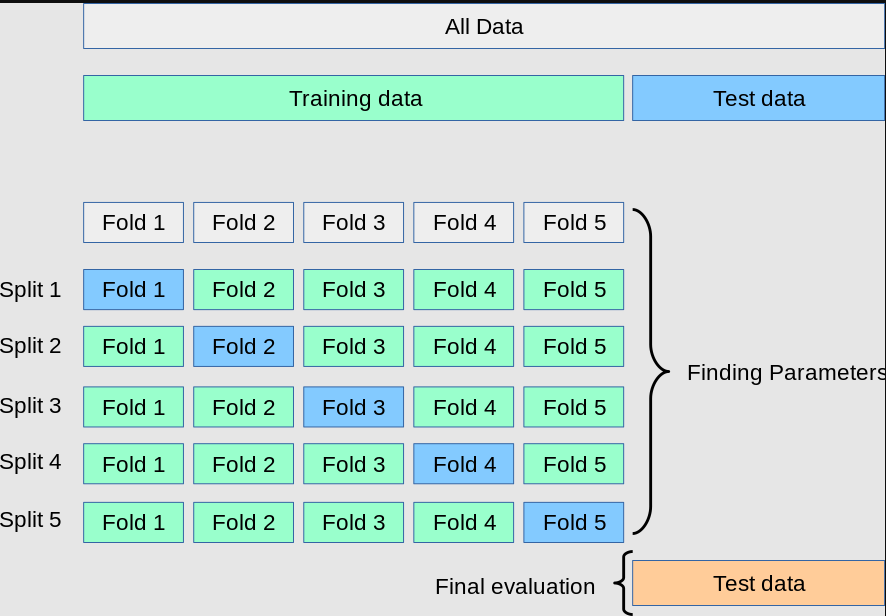

Метод `cross_val_score()` позволяет сделать это всё автоматически. На вход подаётся модель и обучающий набор данных, также можно указать число *k* и метрику для оценки работы модели. Это позволяет применить кросс-валидацию в *k* шагов для любой модели.

### Создаём X и y

In [139]:
# axis=1 для колонок
X = df.drop('sales', axis=1)
y = df['sales']

### Разбиение на TRAIN и TEST

In [142]:
from sklearn.model_selection import train_test_split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Масштабирование данных

In [148]:
from sklearn.preprocessing import StandardScaler

In [150]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Создаём модель

In [153]:
from sklearn.linear_model import Ridge

In [155]:
# Специально указываем неудачное значение alpha
model = Ridge(alpha=100)

### Импортируем метод .cross_val_score()

In [158]:
from sklearn.model_selection import cross_val_score

Варианты оценки модели:

https://scikit-learn.org/stable/modules/model_evaluation.html

In [162]:
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

После запуска, данный метод выполнит пять итераций по обучению и оценке работы модели.

In [165]:
scores

array([ -9.32552967,  -4.9449624 , -11.39665242,  -7.0242106 ,
        -8.38562723])

На выходе мы получили значение указанной метрики neg_mean_squared_error для каждой из пяти итераций. 

In [168]:
abs(scores.mean())

8.215396464543607

Мы получили результаты модели для конкретного значения гиперпараметра. В нашем случае - это модель Ridge со значением alpha=100.

### Поиск значений гиперпараметров

In [172]:
model_two = Ridge(alpha=1)

In [174]:
scores = cross_val_score(model_two, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [176]:
scores

array([-3.15513238, -1.58086982, -5.40455562, -2.21654481, -4.36709384])

In [178]:
abs(scores.mean())

3.344839296530695

Видим, что для alpha=1 мы получили заметно лучшие результаты, чем для alpha=100. Однако, полученные здесь результаты немного хуже чем те, которые были получены ранее для разбиения Train | Validation | Test Split. 

Причина в том, что здесь - мы усредняем результаты метрики оценки модели. Для разбиения Train | Validation | Test Split - существует вероятность того, что в Validation попадут такие данные, на которых наша модель будет вести себя лучше, чем на других разбиениях. 

Ещё одна причина - когда выполнялось разбиение Train | Validation | Test Split, то на Train выделялось 70%, и по 15% на Validation и Test; в данном же случае мы взяли 30% на Test и в итоге осталось 70% для кросс-валидации, а поскольку мы выбрали `cv=5`, то на каждой итерации у нас было 14% данных на валидацию и 56% на обучение. Эти цифры получились, когда мы разбивали 70% на 5 частей, то есть 70/5=14. Получается, что на каждой отдельной итерации, мы обучали модель на 56% исходных данных, в то время как для Train | Validation | Test Split обучение происходило на 70% данных. Следовательно, есть хорошая вероятность того, что на каждой отдельной итерации модель обучалась немного хуже, потому что на обучение подавался меньший объём данных.

С другой стороны, если рассмотреть не каждую отдельную итерацию, а все итерации вместе, то мы получим те же самые 70% данных, которые поучаствовали в обучении модели, просто каждая порция поучаствовала не во всех итерациях.

Хоть мы и получили немного худшие результаты, но зато мы получили намного более объективное представление о том, как будет вести себя модель в реальной жизни, так как была проведена проверка на разных разбиениях.

**После выполнения метода `cross_val_score()` мы не получили обученную модель. Мы получили результаты *scores*, но при этом модель не была обучена. Мы должны явно запустить метод `.fit()` на обучающем наборе данных(X_train, y_train), и это как раз будет 70% от исходных данных.**

Почему метод `cross_val_score()` не выполнил обучение модели? Внутри этого метода мы пять раз выполняли обучение модели на разных порциях данных, если говорить о линейной регрессии - то мы пять раз подбирали коэффициенты $\beta$ и каждый раз получали разный набор этих коэффициентов. В итоге, если бы мы захотели получить на выходе уже обученную модель, то становится непонятно, какую из этих пяти моделей выбрать, потому что на каждой итерации мы получали разные модели. Мы не выбираем никакую из этих пяти моделей, задача метода `cross_val_score()` не в том, чтобы обучить модель, а в том, чтобы посмотреть, как будет вести себя модель на различных разбиениях данных. В итоге мы получаем более объективное представление о том, как будет вести себя модель на новых данных.

In [184]:
model_two.fit(X_train, y_train)

Ridge(alpha=1)

### Выполняем финальную оценку работы модели(после этого уже нельзя возвращаться и делать уточнения!)

In [187]:
y_final_test_pred = model_two.predict(X_test)

In [189]:
from sklearn.metrics import mean_squared_error

In [191]:
MSE = mean_squared_error(y_test, y_final_test_pred)
MSE

2.3190215794287514

Получаем финальное значение метрики оценки модели. Таким образом ведёт себя модель на абсолютно новых данных.

---
---

## Кросс-валидация с помощью cross_validate
Функция `cross_validate` отличается от `cross_val_score` двумя аспектами:

1. Эта функция позволяет использовать для оценки несколько метрик
2. Она возвращает не только оценку на тестовом наборе (test score), но и словарь с замерами времени обучения и скоринга, а также - опционально - оценки на обучающем наборе и объекты estimator.

В случае одной метрики для оценки, когда параметр scoring является строкой string, вызываемым объектом callable или значением None, ключи словаря будут следующими:
        
        - ['test_score', 'fit_time', 'score_time']

А в случае нескольких метрик для оценки, возвращаемый словарь будет содержать следующие ключи:

    ['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

`return_train_score` по умолчанию принимает значение False, чтобы сэкономить вычислительные ресурсы. Чтобы посчитать оценки на обучающем наборе, достаточно установить этот параметр в значение True.

### Создаем X и y

In [199]:
# axis=1 для колонок
X = df.drop('sales', axis=1)
y = df['sales']

### Разбиваем данные на Train и Test

In [202]:
from sklearn.model_selection import train_test_split

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Масштабируем данные

In [207]:
from sklearn.preprocessing import StandardScaler

In [209]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Создаём модель

In [212]:
from sklearn.linear_model import Ridge

In [214]:
# Специально указываем неудачное значение alpha
model = Ridge(alpha=100)

### Импортируем метод .cross_validate()

In [217]:
from sklearn.model_selection import cross_validate

Варианты оценки модели:

https://scikit-learn.org/stable/modules/model_evaluation.html

In [220]:
scores = cross_validate(model, X_train, y_train, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'max_error'], cv=10)

In [222]:
scores

{'fit_time': array([0.00168657, 0.        , 0.00097966, 0.00097275, 0.00099635,
        0.00099635, 0.00155759, 0.        , 0.00099683, 0.        ]),
 'score_time': array([0.00149941, 0.00101352, 0.00102091, 0.        , 0.0009973 ,
        0.        , 0.00050998, 0.00098944, 0.00099659, 0.00099659]),
 'test_neg_mean_absolute_error': array([-1.8102116 , -2.54195751, -1.46959386, -1.86276886, -2.52069737,
        -2.45999491, -1.45197069, -2.37739501, -2.44334397, -1.89979708]),
 'test_neg_mean_squared_error': array([ -6.06067062, -10.62703078,  -3.99342608,  -5.00949402,
         -9.14179955, -13.08625636,  -3.83940454,  -9.05878567,
         -9.05545685,  -5.77888211]),
 'test_max_error': array([ -5.89305462,  -6.06524931,  -5.26424161,  -4.29881153,
         -5.61586024, -10.60207363,  -4.73613382,  -6.520936  ,
         -7.37049532,  -5.41946249])}

In [224]:
pd.DataFrame(scores)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_max_error
0,0.001687,0.001499,-1.810212,-6.060671,-5.893055
1,0.000000,0.001014,-2.541958,-10.627031,-6.065249
2,0.000980,0.001021,-1.469594,-3.993426,-5.264242
3,0.000973,0.000000,-1.862769,-5.009494,-4.298812
4,0.000996,0.000997,-2.520697,-9.141800,-5.615860
5,0.000996,0.000000,-2.459995,-13.086256,-10.602074
6,0.001558,0.000510,-1.451971,-3.839405,-4.736134
7,0.000000,0.000989,-2.377395,-9.058786,-6.520936
8,0.000997,0.000997,-2.443344,-9.055457,-7.370495
9,0.000000,0.000997,-1.899797,-5.778882,-5.419462


In [226]:
pd.DataFrame(scores).mean()

fit_time                        0.000819
score_time                      0.000802
test_neg_mean_absolute_error   -2.083773
test_neg_mean_squared_error    -7.565121
test_max_error                 -6.178632
dtype: float64

### Уточнение значений гиперпараметров

In [229]:
model_two = Ridge(alpha=1)

In [237]:
scores = cross_validate(model_two, X_train, y_train, 
                        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'max_error'], cv=10)

In [239]:
pd.DataFrame(scores)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_max_error
0,0.000996,0.001020,-1.457174,-2.962508,-2.680446
1,0.000513,0.000995,-1.555308,-3.057378,-3.251285
2,0.000000,0.001004,-1.238770,-2.173740,-2.708825
3,0.000993,0.001004,-0.768938,-0.833034,-1.495801
4,0.000000,0.000993,-1.434489,-3.464018,-4.427072
5,0.001005,0.000992,-1.494316,-8.232647,-9.637507
6,0.000000,0.001005,-1.081362,-1.905864,-3.006887
7,0.000992,0.000000,-1.250011,-2.765048,-4.279490
8,0.000044,0.000984,-1.580971,-4.989505,-6.052545
9,0.000992,0.001065,-1.223326,-2.846438,-3.732716


In [241]:
pd.DataFrame(scores).mean()

fit_time                        0.000553
score_time                      0.000906
test_neg_mean_absolute_error   -1.308467
test_neg_mean_squared_error    -3.323018
test_max_error                 -4.127257
dtype: float64

### Вычисляем финальные метрики на тестовом наборе данных (после этого уже нельзя возвращаться и делать уточнения!)

In [244]:
model_two.fit(X_train, y_train)

Ridge(alpha=1)

In [246]:
y_final_pred = model_two.predict(X_test)

In [248]:
from sklearn.metrics import mean_squared_error

In [250]:
MSE = mean_squared_error(y_test, y_final_pred)
MSE

2.3190215794287514

Получаем финальную метрику, которая является оценкой того, как будет вести себя модель на абсолютно новых данных, которые она никогда не видела ранее.

---